# Importando os Dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

full_data = pd.concat([train.drop('Survived', axis=1), test], ignore_index=True)

Vamos iniciar olhando os arquivos de dados de treino, para realizarmos a limpeza dos dados.

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

# Análise Exploratória dos Dados

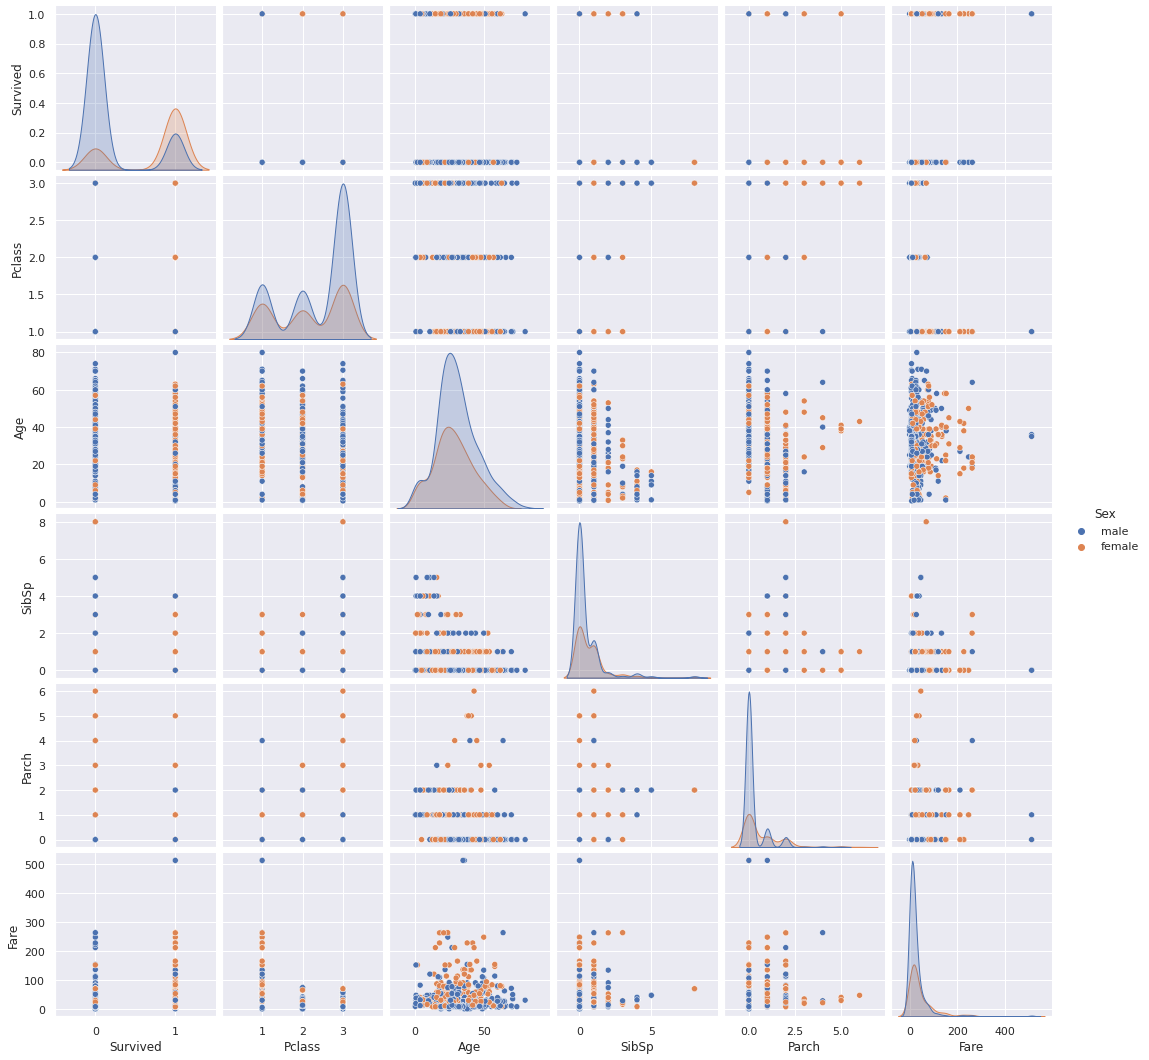

In [6]:
sns.pairplot(train.drop(['PassengerId', 'Name'], axis=1), hue='Sex')

Um aspecto importante de olharmos de cara são as distribuições de cada variável. Ou seja, as distribuição de idade das pessoas do navio, sexo, classe econômica, cabines... Antes mesmo de olharmos mais a fundo para as relações dessas variáveis com a taxa de sobrevivência.

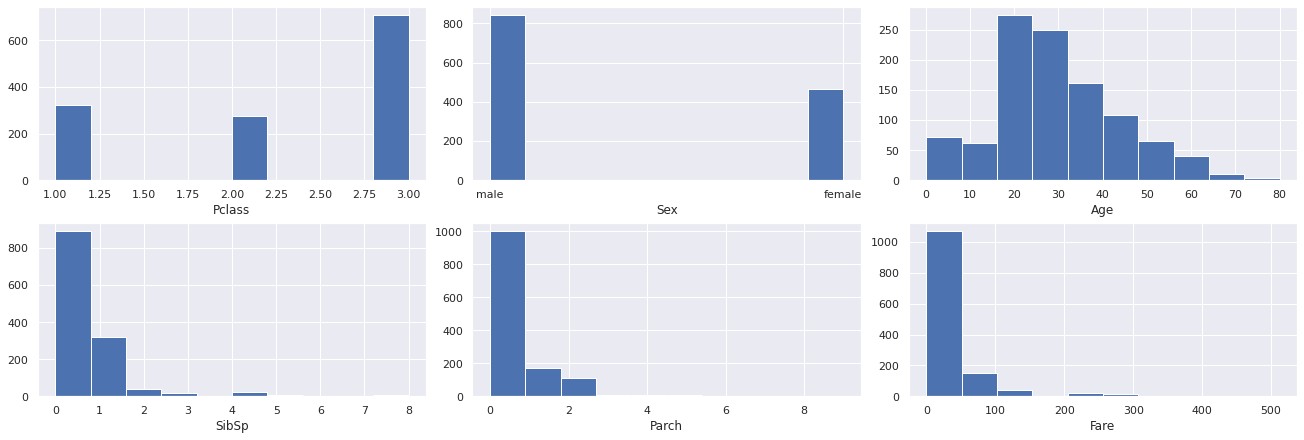

In [7]:
# Cria os gráficos de distribuição em subplots
rows = 2; columns = 3

Xs = train.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin', 'Embarked'], axis = 1).columns #['Age', 'Pclass', 'Fare', 'Parch']

fig, axs = plt.subplots(rows, columns,  figsize=(18, 6), constrained_layout=True)

count = 0
for i in range(rows):
    for j in range(columns):
        axs[i][j].hist(full_data[Xs[count]])
        axs[i][j].set_xlabel(Xs[count])
        
        count += 1

(array([914.,   0.,   0.,   0.,   0., 270.,   0.,   0.,   0., 123.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

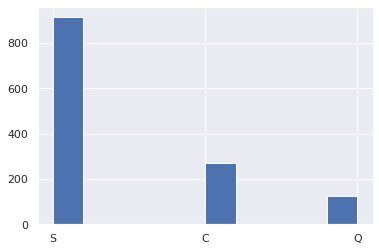

In [8]:
plt.hist(full_data.Embarked.dropna(axis=0, how='any'))

Para a distribuição de idades no navio vamos tentar determinar a forma funcional da distribuição. Com essa forma em mãos poderemos fazer "chutes educados" em valores faltantes (NaN) de idade no nosso banco de dados caso necessário.

Esse método também poderá ser extendido para outras variáveis se assim for necessário. 

<IPython.core.display.Math object>

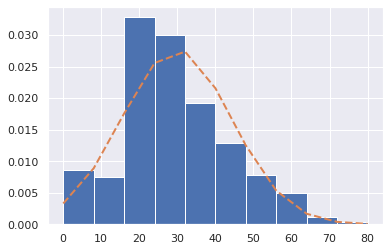

In [9]:
from scipy.stats import norm
from sklearn.metrics import r2_score
from IPython.display import display, Math

fit_data = full_data.Age.dropna(axis=0, how='any')

# normal fit of data
mu, sigma = norm.fit(fit_data)

# the histogram of the data
n, bins, patches = plt.hist(fit_data, density=True)

# fitted normal probability distribution 
best_fit_line = norm.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line, '--', linewidth=2.0)

# r2 of the fit
display(Math(r'R^2: {} \\'.format(r2_score(best_fit_line[1:], n))))

Para avaliarmos a distribuição de cabines teremos de fazer um agrupamento pelas iniciais das cabines. Parece que cada cabine recebe uma letra e um número como identificação. 

In [10]:
train.Cabin.value_counts

<bound method IndexOpsMixin.value_counts of 0       NaN
1       C85
2       NaN
3      C123
4       NaN
       ... 
886     NaN
887     B42
888     NaN
889    C148
890     NaN
Name: Cabin, Length: 891, dtype: object>

Portanto, letras distantes provavelmente indicam localizações muito distintas das cabines, enquanto que cabines com mesma inicial mas números diferentes devem ter certa proximidade no navio. 

Assim, a identificação da cabine deve ser uma variável preditora relevante, imaginando que diferentes regiões do navio devem ter experenciado o naufrago de formas distintas. 

In [11]:
# Cria uma coluna no dataframe com a variável Setor

def sector_classificator(x):
    if x == 'nan':
        return np.nan
    else:
        return x[0]
    
train['Sector'] = train.Cabin.apply(lambda x: sector_classificator(str(x)))

In [12]:
train.Sector

0      NaN
1        C
2      NaN
3        C
4      NaN
      ... 
886    NaN
887      B
888    NaN
889      C
890    NaN
Name: Sector, Length: 891, dtype: object

Agora podemos olhar em como os números de sobreviventes se relacionam com as nossas variáveis preditoras.

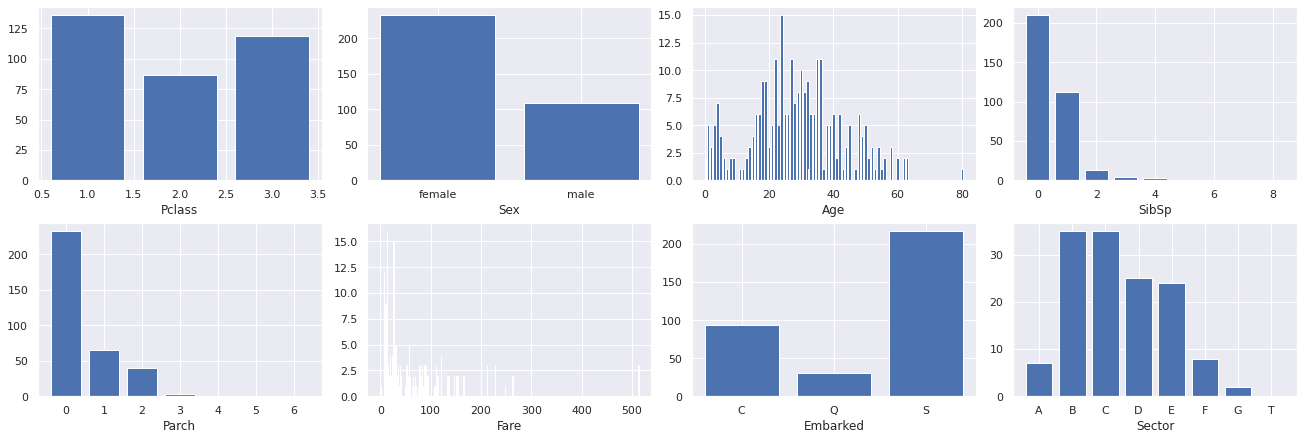

In [13]:
# Cria Subplots
rows = 2; columns = 4

Xs = train.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis = 1).columns #['Age', 'Pclass', 'Fare', 'Parch']

fig, axs = plt.subplots(rows, columns,  figsize=(18, 6), constrained_layout=True)

count = 0
for i in range(rows):
    for j in range(columns):
        bar_serie = train.groupby(Xs[count]).Survived.sum()
        # train.groupby('Sex').Survived.apply(lambda x: x.sum()/891)
    
        axs[i][j].bar(bar_serie.index, bar_serie)
        axs[i][j].set_xlabel(Xs[count])
    
        count += 1
    
#axs[0].set_ylabel('Number of Survivors')

No entanto os gráficos de número de sobreviventes não é uma métrica boa. O motivo para isso é que ela não permite tirar conclusões robustas, vejamos por exemplo o número de sobreviventes por pais/filhos à bordo (**parch**).

Olhando para o gráfico parece que quantos mais parch menos os sobreviventes, no entanto, provavelmente também teremos menos pessoas satisfazendo essa categoria no navio. Portanto uma métrica mais interessante seria olharmos para a fração de pessoas que, com determinado **parch**, sobreviveram.

Text(0.5, 0.98, 'Survival Fraction')

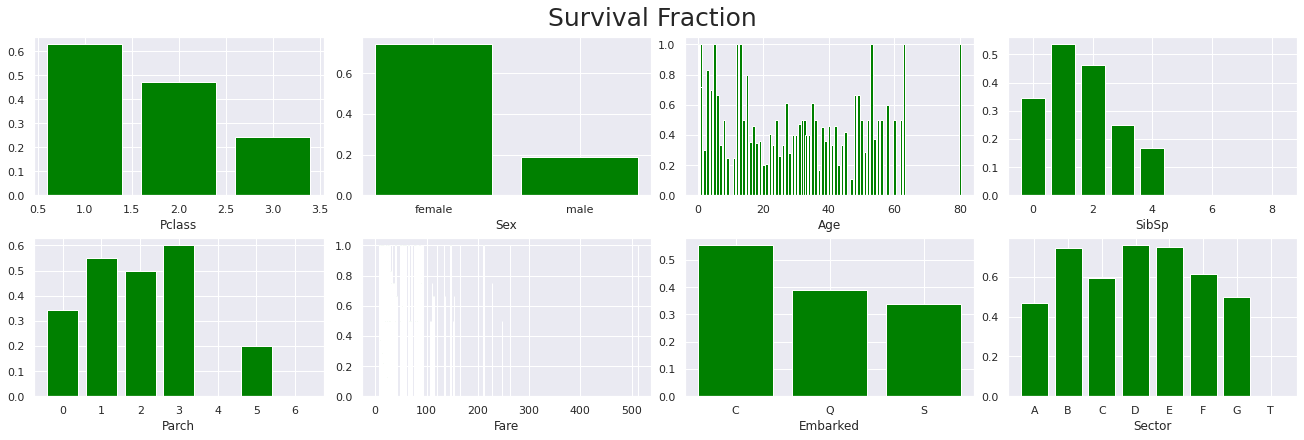

In [14]:
# Cria Subplots com uma melhor métrica
rows = 2; columns = 4

Xs = train.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis = 1).columns #['Age', 'Pclass', 'Fare', 'Parch']

fig, axs = plt.subplots(rows, columns,  figsize=(18, 6), constrained_layout=True)

count = 0
for i in range(rows):
    for j in range(columns):        
        df = train.groupby(Xs[count]).Survived.sum()
        df_index = df.index
    
        bar = []
        for index in df_index:
            bar.append(df[index] / train[train[Xs[count]] == index].shape[0])
        
        axs[i][j].bar(df_index, bar, color='green')
        axs[i][j].set_xlabel(Xs[count])
    
        count += 1
    
#axs[0].set_ylabel('Survival Probability')
fig.suptitle('Survival Fraction', fontsize=25)

Esses gráficos são muito mais esclarecedores. 

Agora, conseguimos observar melhor relações entre as variáveis preditoras com a **probabilidade de sobrevivência**. 

Primeiramente, aquela aparente relação dos números de **parch** com a **probabilidade de sobrevivência** parece ter sido totalmente jogada para o ralo. Agora quem possui *3 parchs* foram os que mais sobreviveram !

Enquanto isso, agora a classe do navio (**Pclass**) parece ser um fator fundamental na sobrevivência dos tripulantes, note como a fração de sobreviventes decaiu enquanto a classe piorava. O mesmo ocorreu com a região de embarque (**Embarked**).

O sexo(**Sex**) parece ser determinante também na taxa de sobrevivência, com as mulheres sobrevivendo ao desastre quase 4x mais que os homens !

As outras variáveis (**Age, SibSp, Fare** e **Sector**) merecem um olhar diferente. Os gráficos ou não apresentaram qualquer relação espefíca com a taxa de sobrevivência ou não apresentaram de forma tão simples (o curioso formato de sino no gráfico de **SibSp**). Mas isso não significa que não haja relação. 

Vale a pena agora estudarmos também se existe algum tipo de correlação entre as variáveis. Isso permitirá que descartemos variáveis altamente correlacionadas em pról da simplicidade do modelo.

Olhar para a matriz de correlação entre as variáveis pode ser importante para evitarmos multicolinearidade entre as variáveis preditoras.

<AxesSubplot:>

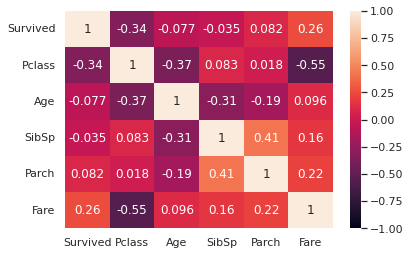

In [15]:
sns.heatmap(train[['Survived', 
                   'Pclass', 
                   'Sex', 
                   'Age', 
                   'SibSp',
                   'Parch', 
                   'Fare', 
                   'Embarked',
                   'Sector']].corr(), vmin=-1, vmax=1, annot=True)

Pela matriz notamos que algumas variáveis de fato possuem correlações significativas com outras. No entanto, nada forte o suficiente para podermos descartar alguma do modelo à priori.

Apartir das nossas análises exploratórias podemos agora escolher quais variáveis preditoras serão usadas. 

Um doas aspectos mais importantes para serem levados em consideração aqui é o número de dados disponíveis em cada categoria. Por exemplo, apenas **147** passageiros do banco de dados possuem informação da cabine usada, de um total de **891** passageiros. Significando que se decidirmos usar essa variável teremos de trabalhar apenas com **16%** do banco de dados originais.

Além disso, algumas das colunas do grupo de dados são irrelevantes para o processo de classificação. Afinal, o nome de um passageiro não terá efeito se ele irá sobreviver ou não.

Dito isso, vamos iniciar nossa análise considerando apenas as seguintes variáveis preditoras: ***Pclass, Sex, Age, Fare, Embarked***

In [16]:
train = train[['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked']]

In [17]:
for column in train.columns:
    print('{} : {}'.format(column, train[column].isnull().values.any()))

Survived : False
Pclass : False
Sex : False
Age : True
Fare : False
Embarked : True


Vamos retirar todas as linhas do banco de dados com NAN. Caso nosso conjunto de dados restantes sejam insuficientes para a análise, posteriormente, podemos retornar aos dados originais e avaliar se os dados faltantes são passíveis de substituição.

In [18]:
train = train.dropna(how = 'any')

In [19]:
print(train.shape)

(712, 6)


De fato perdemos dados do banco original, restando **712/891 = 80%** dos dados originais.

In [20]:
train.describe()

,Survived,Pclass,Age,Fare
count,712.000000,712.000000,712.000000,712.000000
mean,0.404494,2.240169,29.642093,34.567251
std,0.491139,0.836854,14.492933,52.938648
min,0.000000,1.000000,0.420000,0.000000
25%,0.000000,1.000000,20.000000,8.050000
50%,0.000000,2.000000,28.000000,15.645850
75%,1.000000,3.000000,38.000000,33.000000
max,1.000000,3.000000,80.000000,512.329200


In [21]:
train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked
0,0,3,male,22.0,7.2500,S
1,1,1,female,38.0,71.2833,C
2,1,3,female,26.0,7.9250,S
3,1,1,female,35.0,53.1000,S
4,0,3,male,35.0,8.0500,S


Note que temos **3** variáveis preditoras categóricas. Para trabalharmos com elas vamos convertê-las para dummy variables (0 e 1).

In [22]:
train = pd.get_dummies(train, columns = ['Pclass', 'Sex', 'Embarked'])

In [23]:
train.head()

,Survived,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,22.0,7.2500,0,0,1,0,1,0,0,1
1,1,38.0,71.2833,1,0,0,1,0,1,0,0
2,1,26.0,7.9250,0,0,1,1,0,0,0,1
3,1,35.0,53.1000,1,0,0,1,0,0,0,1
4,0,35.0,8.0500,0,0,1,0,1,0,0,1


Para finalizar a preparação vamos arrumar também os dados para teste.

No entanto, aqui devemos tomar cuidado. Esse conjunto de dados é o conjunto de passageiros que devemos realizar a previsão com nosso modelo futuro, para todo e qualquer passageiro nele! Ou seja, não podemos simplesmente remover os passageiros com valores faltantes como fizemos com nosso conjunto de treino.

In [24]:
test = test[['PassengerId','Pclass', 'Sex', 'Age', 'Fare', 'Embarked']]

#test = test.dropna(how = 'any')
test = pd.get_dummies(test, columns = ['Pclass', 'Sex', 'Embarked'])

test.describe()

,PassengerId,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
count,418.000000,332.000000,417.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,1100.500000,30.272590,35.627188,0.255981,0.222488,0.521531,0.363636,0.636364,0.244019,0.110048,0.645933
std,120.810458,14.181209,55.907576,0.436934,0.416416,0.500135,0.481622,0.481622,0.430019,0.313324,0.478803
min,892.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,996.250000,21.000000,7.895800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1100.500000,27.000000,14.454200,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,1204.750000,39.000000,31.500000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,1309.000000,76.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


E note que, no conjunto de teste, **86 (418 - 332)** passageiros possuem dados sobre a sua idade (**Age**) faltando, assim como um passageiros não possui informação sobre a taxa paga (**Fare**).

In [25]:
test.head()

,PassengerId,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,892,34.5,7.8292,0,0,1,0,1,0,1,0
1,893,47.0,7.0000,0,0,1,1,0,0,0,1
2,894,62.0,9.6875,0,1,0,0,1,0,1,0
3,895,27.0,8.6625,0,0,1,0,1,0,0,1
4,896,22.0,12.2875,0,0,1,1,0,0,0,1


Para podermos avaliar a capacidade de cada modelo vamos separar mais os dados de treino. Deixando uma parte deles para verificar os resultados. 

In [26]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(train.drop('Survived', axis=1), train.Survived, random_state = 0)

Agora estamos prontos para fazermos nossas análises

# Análise e Classificação

Afim de obtermos o melhor output vamos treinar diversos modelos iniciando por um modelo de *decision tree*, passando por *random forests*, *support vector machines*, *naive bayes* e por fim *logistic regression*.

In [27]:
# DECISION TREE
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier().fit(Xtrain, ytrain)

tree_predictions = tree_model.predict(Xtest)

tree_model.score(Xtest, ytest)

0.7640449438202247

In [28]:
# RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier(n_estimators = 100).fit(Xtrain, ytrain)

forest_predictions = forest_model.predict(Xtest)

forest_model.score(Xtest, ytest)

0.797752808988764

In [29]:
# LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression(solver='liblinear').fit(Xtrain, ytrain)

logistic_predictions = logistic_model.predict(Xtest)

logistic_model.score(Xtest, ytest)

0.8033707865168539

In [30]:
# SUPPORT VECTOR MACHINE LINEAR KERNEL
from sklearn import svm

svm_model = svm.SVC(kernel='linear').fit(Xtrain, ytrain)

svm_predictions = svm_model.predict(Xtest)

svm_model.score(Xtest, ytest)

0.7696629213483146

In [31]:
# NAIVE BAYES GAUSSIAN
from sklearn.naive_bayes import GaussianNB

bayes_model = GaussianNB().fit(Xtrain, ytrain)
bayes_predictions = bayes_model.predict(Xtest)

bayes_model.score(Xtest, ytest)

0.7640449438202247

Afim de avaliarmos efetivamente a capacidade dos modelos vamos avaliar a curva ROC para cada um. 

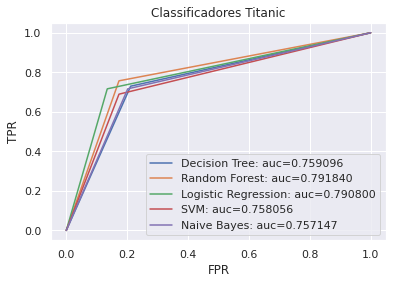

In [32]:
from sklearn.metrics import roc_curve, auc

prediction_dict = {'Decision Tree': tree_predictions, 
                   'Random Forest':forest_predictions, 
                   'Logistic Regression' :logistic_predictions, 
                   'SVM': svm_predictions, 
                   'Naive Bayes': bayes_predictions}

for model in prediction_dict:
    fpr, tpr, thresholds = roc_curve(ytest, prediction_dict[model])
    auc_score = auc(fpr, tpr)
    
    label = '%s: auc=%f' % (model, auc_score)
    plt.plot(fpr, tpr, label = label)

plt.ylabel('TPR')
plt.xlabel('FPR')
plt.legend(loc='lower right')
plt.title('Classificadores Titanic')
plt.show()

Apesar dos modelos serem bem próximos na acurácia, o modelo com melhor desempenho foi o de **Regressão Logística** como podemos ver pelo *AUC* mais próximo de **1.0** dentre os modelos testados.

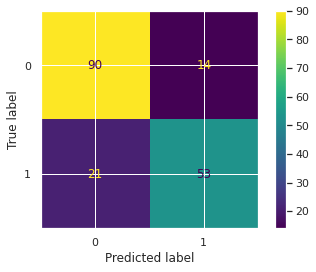

In [33]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(logistic_model, Xtest, ytest)

# Resultados

Através do modelo de regressão logística podemos realizar as previsões para os dados originais de teste, uma vez que foi o modelo que apresentou melhor desempenho, dentre os modelos testados, com os dados utilizados.  

No entanto, antes disso vamos realizar algumas operações no conjunto de dados de teste.

In [34]:
test.describe()

,PassengerId,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
count,418.000000,332.000000,417.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,1100.500000,30.272590,35.627188,0.255981,0.222488,0.521531,0.363636,0.636364,0.244019,0.110048,0.645933
std,120.810458,14.181209,55.907576,0.436934,0.416416,0.500135,0.481622,0.481622,0.430019,0.313324,0.478803
min,892.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,996.250000,21.000000,7.895800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1100.500000,27.000000,14.454200,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,1204.750000,39.000000,31.500000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,1309.000000,76.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Vamos utilizar da distribuição de idade para completar os valores faltantes no conjunto de teste de forma aleatória.

In [35]:
# Funcao para trocar os valores faltantes por um valor aleatorio retirado da distribuição normal de idades
def replace_age(x):
    if np.isnan(x):
        return np.random.normal(mu, sigma)
    else:
        return x
    
test['Age'] = test.Age.apply(lambda x: replace_age(x))

test.Age

0      34.500000
1      47.000000
2      62.000000
3      27.000000
4      22.000000
         ...    
413    40.340449
414    39.000000
415    38.500000
416    21.181809
417    -3.704264
Name: Age, Length: 418, dtype: float64

Para finalizar a preparação dos dados de teste vamos preencher o valor faltante no **Fare** pela sua respectiva média. Esse método parece ser o mais adequado uma vez que só teremos de preencher um valor no conjunto de dados.

In [36]:
test['Fare'] = test.Fare.fillna(value=test.Fare.mean())

Agora podemos aplicar o nosso modelo e realizar as revisões do conjunto de teste.

In [37]:
test.describe()

,PassengerId,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,1100.500000,30.454728,35.627188,0.255981,0.222488,0.521531,0.363636,0.636364,0.244019,0.110048,0.645933
std,120.810458,14.624475,55.840500,0.436934,0.416416,0.500135,0.481622,0.481622,0.430019,0.313324,0.478803
min,892.000000,-11.749691,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,996.250000,21.000000,7.895800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1100.500000,28.491120,14.454200,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,1204.750000,40.000000,31.500000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,1309.000000,76.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [38]:
# Treino e Previsão do modelo com os dados completos de treino e teste
logistic_model = LogisticRegression(solver='liblinear').fit(train.drop('Survived', axis=1), train.Survived) 

logistic_predictions = logistic_model.predict(test.drop('PassengerId', axis=1))

In [39]:
output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': logistic_predictions})

output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [40]:
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
